In [8]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

from src.utils.data_utils import TGIF, MMNist
from src.utils.trainer import ModelTrainer

from src.models.vae import VAE, Initializer

import matplotlib.pyplot as plt


import numpy as np
import os

%load_ext autoreload
%autoreload 2


TEST_MODEL_PATH = os.path.join(os.getcwd(), 'src', 'experiments', 'vaegan-mmnist')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
def deprocess(img):
    transform = transforms.Compose([
        transforms.Lambda(rescale),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled



In [10]:
USE_GPU = True

dtype = torch.float32
# dtype = torch.uint8
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using device:', device)
print('Using type:', dtype)

Using device: cuda
Using type: torch.float32


In [11]:
IMAGE_SZ = (64, 64)


MAX_FRAMES = 10

DATASET_ROOT = '/home/deepdeepfakes/cs231n-project/src/datasets/MMNIST'

train_set = MMNist(f'{DATASET_ROOT}/train_set.npz',
                   transform=transforms.Compose([
#                         transforms.Resize(IMAGE_SZ), 
#                         transforms.ToPILImage(),                       
                        transforms.ToTensor()
                    ]),
)

val_set = MMNist(f'{DATASET_ROOT}/val_set.npz',
                   transform=transforms.Compose([
#                         transforms.Resize(IMAGEw_SZ), 
#                         transforms.ToPILImage(),
                        transforms.ToTensor()
                         
                    ]),
)


In [12]:
BATCH_SZ = 128
NUM_WORKERS = 4

overfit_train_loader = DataLoader(train_set, 
                               batch_size=BATCH_SZ, 
                               num_workers=NUM_WORKERS, 
                               drop_last=True,
                               sampler=sampler.SubsetRandomSampler([i for i in range(178, 178 + BATCH_SZ)]))


train_loader = DataLoader(train_set, batch_size=BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_set, batch_size=BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)

print(len(train_set), len(val_set)) #, len(test_set))

z = val_set[0]
print(torch.max(z))
# torch.nonzero(z)
# print(z[1307])
# print(z.to(dtype=dtype)[1307])

80000 10000
tensor(1.)


torch.Size([20, 1, 64, 64])


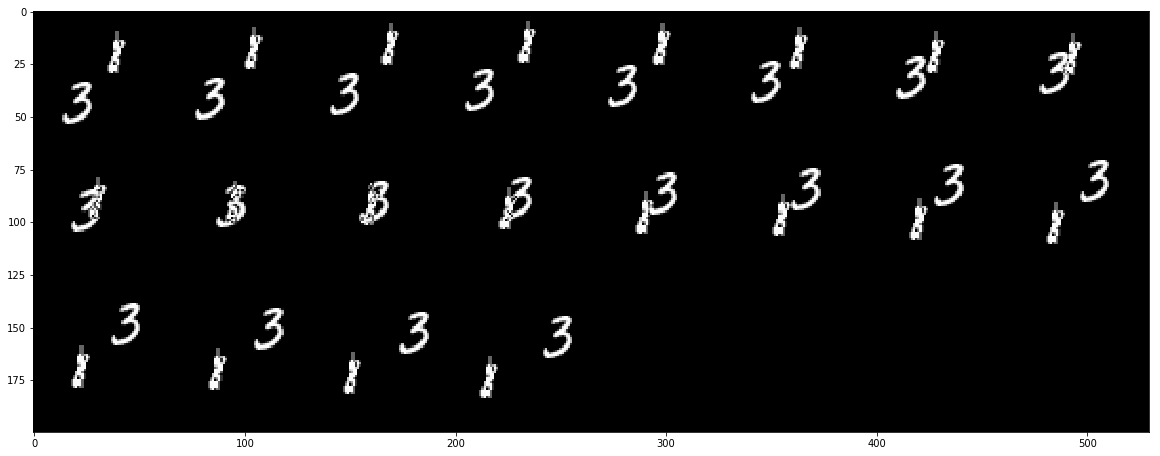

In [13]:
%matplotlib inline


plt.figure(figsize=(20, 20))

dataiter = iter(train_loader)
gif = dataiter.next()[0]

print(gif.shape)

def imshow(img, save_file=None):
    npimg = img.numpy()

    out = np.transpose(npimg, (1, 2, 0))



    if save_file:
        plt.imsave(save_file, out)
        
    plt.imshow(out)
    
imshow(torchvision.utils.make_grid(gif))


    


In [7]:
%matplotlib inline
from IPython import display
import time


def img_show(gif):
    npimg = gif.numpy()
    out = np.transpose(npimg, (1, 2, 0))
    plt.figure(figsize=(20,40))
    plt.imshow(out)


def plot_frame_single(index, frame):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    fig.subplots_adjust(hspace=0)
    npframe = frame.numpy()
    npframe = np.transpose(npframe, (1, 2, 0)).squeeze()
    ax.imshow(npframe)
    ax.set_title(f'FRAME #{index + 1}')
    plt.gcf().show()
    
def make_gif(model, seed_frame, gif_length=10):
    curr_h = model.init_hidden(BATCH_SZ)
    curr_x = seed_frame.to(device=device, dtype=dtype)
    ret = [seed_frame]
    
    for i in range(gif_length - 1): 
        y, curr_h = model(curr_x, curr_h)
        curr_x = y
        ret.append(y.to(device = torch.device('cpu')))
    
    return torch.stack(ret).transpose(0, 1).squeeze()


def display_loop(gif):
    for index, frame1 in enumerate(gif):

        plot_frame_single(index, frame1)

        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.15)
        
# display_loop(gif)
    

In [11]:


def train_fn(model, optimizer, inp):
    
    def loss_fn(recon_x, x, mu, logvar, kl_reg=1e-12):
        mse_loss = nn.L1Loss(size_average=True)
        MSE = mse_loss(recon_x, x)            

        KLD = kl_reg * (-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()))

        loss = MSE + KLD
        return loss


    
    model.train()         
    
#     x = inp[:, 0, :, :, :]
    x = inp
#     N, T, C, H, W = inp.shape
#     x = inp.view(-1, C, H, W)

    x = x.to(device=device, dtype=dtype)

    recon_x, mu, logvar = model(x)
    
#     print('---', x.shape, recon_x.shape)

    loss = loss_fn(recon_x, x, mu, logvar)

    loss.cuda().backward()
    optimizer.step()
    
    optimizer.zero_grad()
    
    return loss.item()

## Train network

In [14]:
NUM_CHANNELS = 1
INPUT_SIZE = IMAGE_SZ[0] * IMAGE_SZ[1] * NUM_CHANNELS   
HIDDEN_SIZE = INPUT_SIZE
OUTPUT_SIZE = INPUT_SIZE


net = VAE(latent_size=512, num_channels=1, device=device)

Initializer.initialize(model=net, initialization=init.xavier_uniform_, gain=init.calculate_gain('relu'))

# optimizer = optim.SGD(net.parameters(), lr=1e-6, momentum=0.9, nesterov=True)
optimizer = optim.Adam(net.parameters(), lr=1e-3)
trainer = ModelTrainer(net, optimizer, train_fn, TEST_MODEL_PATH, save_models=False)

In [27]:



# optimizer = optim.Adam(net.parameters(), lr=1e-4)
 
print('Starting training...')
trainer.train(train_loader, epochs=1, print_every=50, save_every=100)

Starting training...
Epoch [0] (0/12500), loss = 0.0192
Epoch [0] (50/12500), loss = 0.0168
Epoch [0] (100/12500), loss = 0.0168
Epoch [0] (150/12500), loss = 0.0163
Epoch [0] (200/12500), loss = 0.0159
Epoch [0] (250/12500), loss = 0.0159
Epoch [0] (300/12500), loss = 0.0157
Epoch [0] (350/12500), loss = 0.0147
Epoch [0] (400/12500), loss = 0.0163
Epoch [0] (450/12500), loss = 0.0152
Epoch [0] (500/12500), loss = 0.0151
Epoch [0] (550/12500), loss = 0.0150
Epoch [0] (600/12500), loss = 0.0144
Epoch [0] (650/12500), loss = 0.0145
Epoch [0] (700/12500), loss = 0.0149
Epoch [0] (750/12500), loss = 0.0150
Epoch [0] (800/12500), loss = 0.0143
Epoch [0] (850/12500), loss = 0.0153
Epoch [0] (900/12500), loss = 0.0149
Epoch [0] (950/12500), loss = 0.0147
Epoch [0] (1000/12500), loss = 0.0147
Epoch [0] (1050/12500), loss = 0.0149
Epoch [0] (1100/12500), loss = 0.0144
Epoch [0] (1150/12500), loss = 0.0142
Epoch [0] (1200/12500), loss = 0.0146
Epoch [0] (1250/12500), loss = 0.0145
Epoch [0] (130

Epoch [0] (10800/12500), loss = 0.0123
Epoch [0] (10850/12500), loss = 0.0131
Epoch [0] (10900/12500), loss = 0.0131
Epoch [0] (10950/12500), loss = 0.0124
Epoch [0] (11000/12500), loss = 0.0119
Epoch [0] (11050/12500), loss = 0.0124
Epoch [0] (11100/12500), loss = 0.0127
Epoch [0] (11150/12500), loss = 0.0125
Epoch [0] (11200/12500), loss = 0.0122
Epoch [0] (11250/12500), loss = 0.0126
Epoch [0] (11300/12500), loss = 0.0128
Epoch [0] (11350/12500), loss = 0.0125
Epoch [0] (11400/12500), loss = 0.0120
Epoch [0] (11450/12500), loss = 0.0124
Epoch [0] (11500/12500), loss = 0.0122
Epoch [0] (11550/12500), loss = 0.0138
Epoch [0] (11600/12500), loss = 0.0123
Epoch [0] (11650/12500), loss = 0.0124
Epoch [0] (11700/12500), loss = 0.0127
Epoch [0] (11750/12500), loss = 0.0125
Epoch [0] (11800/12500), loss = 0.0121
Epoch [0] (11850/12500), loss = 0.0126
Epoch [0] (11900/12500), loss = 0.0119
Epoch [0] (11950/12500), loss = 0.0124
Epoch [0] (12000/12500), loss = 0.0120
Epoch [0] (12050/12500), 

In [28]:
# trainer.save_models = True
# trainer.save_data()

# trainer = ModelTrainer(net, optimizer, train_fn, TEST_MODEL_PATH, save_models=False)
# trainer.load_model('1527480856.120883')

tensor(1., device='cuda:0') tensor(0., device='cuda:0')


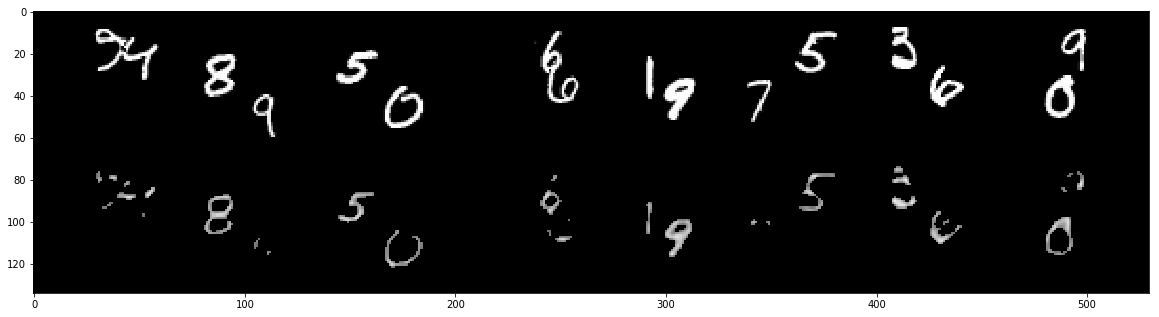

In [30]:
def sample(model, seed_frame, gif_length=10):
    curr_h = model.init_hidden(BATCH_SZ)
    curr_x = seed_frame.to(device=device, dtype=dtype)
    model.eval()
    ret = [seed_frame]
    
    for i in range(gif_length - 1):
        y, curr_h = model(curr_x, curr_h)
        curr_x = y   # TODO: maybe sample from probability?
        ret.append(y.to(device = torch.device('cpu')))
        
    
    return torch.stack(ret).transpose(0, 1)


plt.figure(figsize=(20,40))

    
DISP_LIM = 8

def test_autoenc(model, loader):
    model.eval()
    dataiter = iter(loader)
    
    x = dataiter.next()
#     x = x[0]

    


    x = x.to(device=device, dtype=dtype)


    
    y, mu, logvar = model(x)
    y = deprocess(y)
    
    print(torch.max(y), torch.min(y))
    
    x = x.to(torch.device('cpu')).detach()
    
#     y = torch.clamp(y.to(torch.device('cpu'), dtype=torch.uint8).detach(), 0, 255)
    y = y.to(torch.device('cpu')).detach()
    y[y < 0.45] = 0

    
    imgs = torch.cat([x[:DISP_LIM], y[:DISP_LIM]])
    
    imshow(torchvision.utils.make_grid(imgs)) #, save_file='img/train_test_out.png')
    
    
    
    
    

test_autoenc(net, train_loader)

torch.Size([128, 512])
torch.Size([128, 512])


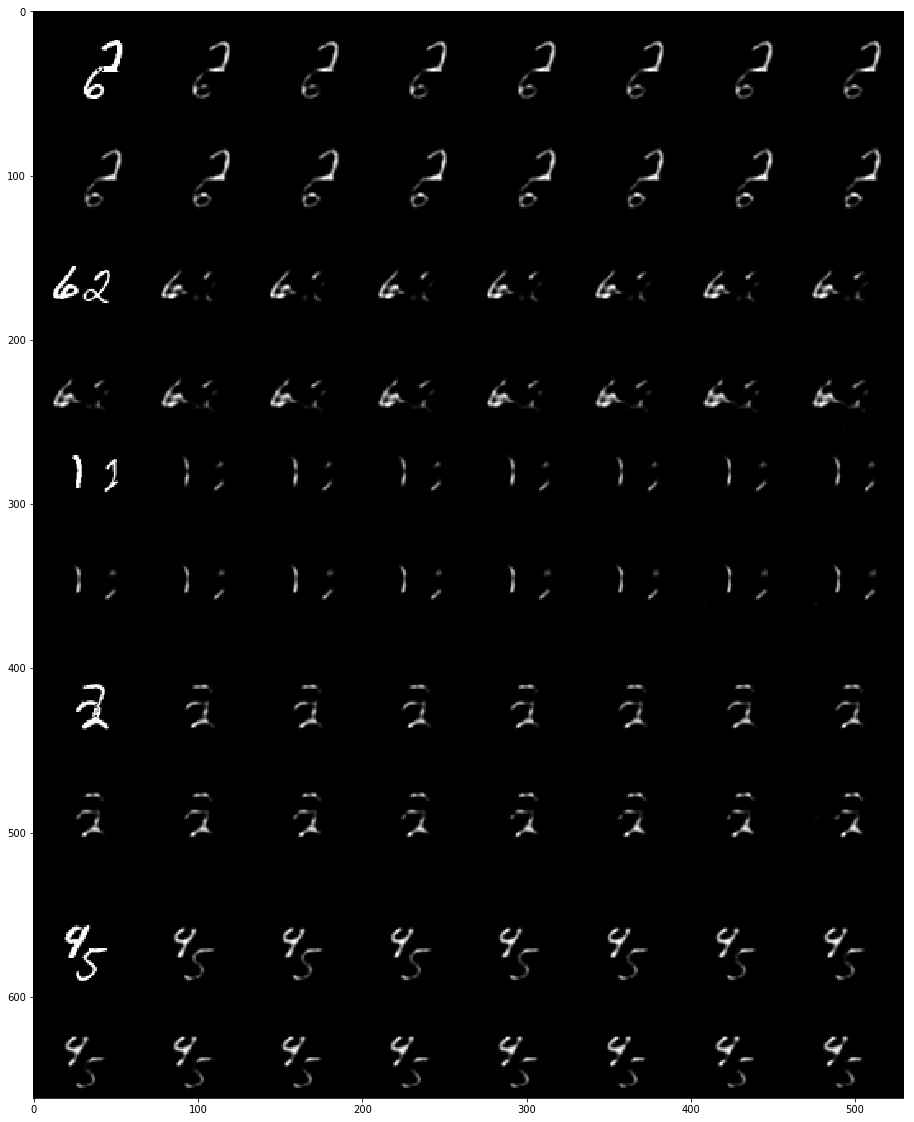

In [31]:
def vary_latent(init_z, step, length, dim, model, orig_img):
    print(init_z.shape)
    BATCH_IDX = 15
    BATCH_LIM = 5
    orig_img = orig_img.to(torch.device('cpu')).detach()

    ret = []
    curr_z = init_z.clone()
    curr_z = curr_z.to(device=device)
    
#     curr_z[dim] -= step*(length // 2)
    
    model.eval()
    for batch in range(BATCH_LIM):
        curr_z = init_z.clone()
        ret.append(orig_img[batch]) 
        for i in range(length):
            curr_z[:, dim] += step
            y = model.decoder(curr_z)
            y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
            ret.append(y[batch])
    
    imshow(torchvision.utils.make_grid(torch.stack(ret)))
        
        
    

def get_latent_z(model, x):
    enc_y = model.encoder(x)
    mu, logvar = model.fc_mu(enc_y), model.fc_logvar(enc_y)
    return model.sample_latent(mu, logvar)


def sample_forward(model, z):
    return model.decoder(z)


def test_varying(model, loader):
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()    
#     x = x[0]
#     x = x[:, 0, :, :, :]
    x = x.to(device=device, dtype=dtype)

    z = get_latent_z(net, x)
    print(z.shape)
    vary_latent(z, 10, 15, 5, net, x)
    
    
def gen_image(model):
    z = torch.randn((64, 100), device=device)
    y = model.decoder(z)
    y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
    img_show(torchvision.utils.make_grid(y))
    
plt.figure(figsize=(20, 20))

test_varying(net, train_loader)

# gen_image(net)